In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_from_disk
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from argparse import Namespace

In [2]:
config = {
    "train_subset": 1500000,
    "valid_subset": 400000,
    "test_subset" : 200000,
    "seed": 42
}

args = Namespace(**config)

### Read the dataset

In [3]:
violence_hidden = load_from_disk("../../Violence_data/geo_corpus.0.0.1_datasets_hidden_labse")

In [4]:
violence_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16769932
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 4192483
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2329158
    })
})

In [5]:
# Remove unncesary columns
keep_cols = ['hidden_state', 'labels']
remove_columns = [col for col in violence_hidden['train'].column_names if col not in keep_cols]

In [6]:
violence_hidden = violence_hidden.remove_columns(remove_columns)

In [7]:
violence_hidden

DatasetDict({
    train: Dataset({
        features: ['labels', 'hidden_state'],
        num_rows: 16769932
    })
    validation: Dataset({
        features: ['labels', 'hidden_state'],
        num_rows: 4192483
    })
    test: Dataset({
        features: ['labels', 'hidden_state'],
        num_rows: 2329158
    })
})

In [8]:
# Extract a subset of the dataset
train_clf_ds = violence_hidden["train"].shuffle(args.seed).select(range(args.train_subset))
validation_clf_ds = violence_hidden["validation"].shuffle(args.seed).select(range(args.valid_subset))
test_clf_ds = violence_hidden["test"].shuffle(args.seed).select(range(args.test_subset))

Loading cached shuffled indices for dataset at ../../Violence_data/geo_corpus.0.0.1_datasets_hidden_labse/train/cache-0f42d9e251c8e3bd.arrow
Loading cached shuffled indices for dataset at ../../Violence_data/geo_corpus.0.0.1_datasets_hidden_labse/validation/cache-92187a45536b8e3c.arrow
Loading cached shuffled indices for dataset at ../../Violence_data/geo_corpus.0.0.1_datasets_hidden_labse/test/cache-57c0da97451c21cd.arrow


In [9]:
train_clf_ds[0]

{'labels': tensor([0., 0., 0., 0., 0., 1.]),
 'hidden_state': tensor([-7.6954e-02, -3.5868e-02,  1.2293e+00, -9.2771e-02,  7.6285e-01,
          1.2228e+00,  1.2598e-01, -1.5125e-01, -1.2606e-01,  4.6174e-01,
         -1.4210e+00, -4.0642e-01, -1.4511e-01,  4.4258e-01, -2.3478e-01,
         -5.1071e-01,  4.6329e-02, -1.2245e-01,  3.5951e-01,  8.2760e-01,
         -1.1671e+00,  5.8337e-02, -2.4783e-02,  5.5890e-01,  2.3697e-01,
          8.6722e-01, -3.8896e-01, -3.8885e-01, -1.0293e-01, -6.7289e-01,
         -4.1553e-01,  6.6248e-01, -2.1274e-01,  2.4683e-01, -4.9157e+00,
          1.7413e-01,  1.2455e-01, -1.2890e-02,  1.2809e+00,  5.7767e-02,
          7.3940e-01, -1.5951e-01,  1.0517e-01,  6.6625e-02,  3.0113e-02,
         -2.2785e-01,  3.9391e-01, -2.0695e-01,  5.4777e-01,  7.0455e-02,
          9.0074e-01, -1.0040e+00,  9.4108e-01, -4.6586e-02, -1.3459e+00,
          3.9281e-01,  6.2495e-01,  3.8502e-01, -8.9493e-02, -2.7856e-01,
          4.3720e-01,  5.3686e-01, -4.1777e-01,  1.

### Create a feature matrix

In [10]:
%time X_train = np.array(train_clf_ds["hidden_state"])
y_train = np.array(train_clf_ds["labels"])
X_validation = np.array(validation_clf_ds["hidden_state"])
y_validation = np.array(validation_clf_ds["labels"])
X_test = np.array(test_clf_ds["hidden_state"])
y_test = np.array(test_clf_ds["labels"])
X_train.shape

CPU times: user 28.6 s, sys: 1min 10s, total: 1min 39s
Wall time: 7min 41s


(1500000, 768)

In [ ]:
print(np.min(X_train[10]))
print(np.max(X_train[10]))

## Helper Functions

In [11]:
# Create a function to report the various metrics for each classifier
def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)
    
    roc_auc = roc_auc_score(test_labels, predictions, average = "weighted")

    weighted_precision = precision_score(test_labels, predictions, average='weighted')
    weighted_recall = recall_score(test_labels, predictions, average='weighted')
    weighted_f1 = f1_score(test_labels, predictions, average='weighted')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    
    
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nroc_auc_score: {:.4f}\nPrecision:\n  - Weighted: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Weighted: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Weighted: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, roc_auc, weighted_precision, micro_precision, weighted_recall, micro_recall, weighted_f1, micro_f1))
    ModelsPerformance[modelName] = {"accuracy": format(accuracy, '.4f'), "roc_auc": format(roc_auc, '.4f'), "weighted_precision": format(weighted_precision, '.4f'),
                                    "weighted_recall": format(weighted_recall, '.4f'), "weighted_f1": format(weighted_f1, '.4f'), "micro_precision": format(micro_precision, '.4f'),
                                    "micro_recall": format(micro_recall, '.4f'), "micro_f1": format(micro_f1, '.4f')}

In [12]:
def plot_confusion_matrix(y_test, y_pred, clf:str):
    f, axes = plt.subplots(2, 3, figsize=(25, 15))
    f.suptitle(clf, fontsize=36)
    axes = axes.ravel()
    for i in range(6):
        labels=['post7geo10', 'post7geo30', 'post7geo50','pre7geo10','pre7geo30', 'pre7geo50']
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                       y_pred[:, i]),
                                      display_labels=[0, i])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(labels[i])
        if i<10:
            disp.ax_.set_xlabel('')
        if i%5!=0:
            disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()

# Classifiers

## Problem transformation

### Bagging

In [13]:
bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1, 
                                                      random_state=args.seed))
%time bagClassifier.fit(X_train, y_train)


CPU times: user 9.18 s, sys: 12.9 s, total: 22.1 s
Wall time: 5h 1min 13s


OneVsRestClassifier(estimator=BaggingClassifier(n_jobs=-1, random_state=42))

In [14]:
%time bagPreds = bagClassifier.predict(X_test)

CPU times: user 1.23 s, sys: 2.39 s, total: 3.63 s
Wall time: 25.6 s


### Boosting

In [22]:
boostClassifier = OneVsRestClassifier(GradientBoostingClassifier(
    random_state=args.seed), n_jobs=-1)
%time boostClassifier.fit(X_train, y_train)

CPU times: user 8.88 s, sys: 13.2 s, total: 22.1 s
Wall time: 22h 12min 50s


OneVsRestClassifier(estimator=GradientBoostingClassifier(random_state=42),
                    n_jobs=-1)

In [23]:
%time boostPreds = boostClassifier.predict(X_test)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
CPU times: user 9.47 s, sys: 7.8 ms, total: 9.48 s
Wall time: 9.46 s


### OneVsRest - Support Vector Machine

In [15]:
# Standardize the data for SVM
X_train_scaled = StandardScaler().fit_transform(X_train)
X_validation_scaled = StandardScaler().fit_transform(X_validation)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [ ]:
svmClassifier = OneVsRestClassifier(LinearSVC(
    random_state=args.seed, max_iter=7000, 
    dual=False, tol=1e-5), n_jobs=-1)
%time svmClassifier.fit(X_train_scaled, y_train)

In [ ]:
%time svmPreds = svmClassifier.predict(X_test)

### Binary Relevance - Support Vector Machine

In [16]:
BinaryRelSVC = BinaryRelevance(LinearSVC(random_state=args.seed,
                                         max_iter=7000, dual=False, 
                                         tol=1e-5),
                                         require_dense = [True, True])
%time BinaryRelSVC.fit(X_train_scaled, y_train)

CPU times: user 4h 33min 52s, sys: 1h 7min 56s, total: 5h 41min 48s
Wall time: 5h 41min 46s


BinaryRelevance(classifier=LinearSVC(dual=False, max_iter=7000, random_state=42,
                                     tol=1e-05),
                require_dense=[True, True])

In [17]:
%time BinRelSVCPreds = BinaryRelSVC.predict(X_test).toarray()

CPU times: user 7.28 s, sys: 16.8 s, total: 24.1 s
Wall time: 3.44 s


## Problem Adaptation

### Decision Trees

In [18]:
dtClassifier = DecisionTreeClassifier(random_state=args.seed)
%time dtClassifier.fit(X_train, y_train)

CPU times: user 1h 29min 33s, sys: 3.26 s, total: 1h 29min 36s
Wall time: 1h 29min 33s


DecisionTreeClassifier(random_state=42)

In [19]:
%time dtPreds = dtClassifier.predict(X_test)

CPU times: user 394 ms, sys: 31.5 ms, total: 425 ms
Wall time: 422 ms


### Random Forest

In [20]:
rfClassifier = RandomForestClassifier(n_jobs=-1, 
                                      random_state=args.seed)
%time rfClassifier.fit(X_train, y_train)

CPU times: user 4h 13min 11s, sys: 36 s, total: 4h 13min 47s
Wall time: 6min 2s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [21]:
%time rfPreds = rfClassifier.predict(X_test)

CPU times: user 48.1 s, sys: 13.9 s, total: 1min 1s
Wall time: 3.07 s


# Model Evaluation

### Evaluate classifiers

In [24]:
ModelsPerformance = {}
metricsReport("Bagging", y_test, bagPreds)
metricsReport("Boosting", y_test, boostPreds)
# metricsReport("SVM-OVR", y_test, svmPreds)
metricsReport("SVM-BR", y_test, BinRelSVCPreds)
metricsReport("Decision Tree", y_test, dtPreds)
metricsReport("Random Forest", y_test, rfPreds)


------Bagging Model Metrics-----
Accuracy: 0.0668
roc_auc_score: 0.5244
Precision:
  - Weighted: 0.5181
  - Micro: 0.5388
Recall:
  - Weighted: 0.4066
  - Micro: 0.4066
F1-measure:
  - Weighted: 0.4454
  - Micro: 0.4635
------Boosting Model Metrics-----
Accuracy: 0.0420
roc_auc_score: 0.5097
Precision:
  - Weighted: 0.6112
  - Micro: 0.5691
Recall:
  - Weighted: 0.4736
  - Micro: 0.4736
F1-measure:
  - Weighted: 0.3917
  - Micro: 0.5170


/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------SVM-BR Model Metrics-----
Accuracy: 0.1012
roc_auc_score: 0.5035
Precision:
  - Weighted: 0.2695
  - Micro: 0.6184
Recall:
  - Weighted: 0.0404
  - Micro: 0.0404
F1-measure:
  - Weighted: 0.0616
  - Micro: 0.0758
------Decision Tree Model Metrics-----
Accuracy: 0.1484
roc_auc_score: 0.5203
Precision:
  - Weighted: 0.4988
  - Micro: 0.5017
Recall:
  - Weighted: 0.5004
  - Micro: 0.5004
F1-measure:
  - Weighted: 0.4994
  - Micro: 0.5010
------Random Forest Model Metrics-----
Accuracy: 0.0719
roc_auc_score: 0.5273
Precision:
  - Weighted: 0.5712
  - Micro: 0.5730
Recall:
  - Weighted: 0.4922
  - Micro: 0.4922
F1-measure:
  - Weighted: 0.4511
  - Micro: 0.5295


In [25]:
print(" Model Name " + " "*3 + "| Acc.   " + " "*1 + "| ROC_AUC " + " "*1 + "| weighted_prec" + " "*1 + "| weighted_rec" + " "*1 + "| weighted_f1" + " "*1 + "| micro_prec" + " "*1 + "| micro_rec" + " "*1 + "| micro_f1")
print("--------------------------------------------------------------------------------------------------------------------")
for key, value in ModelsPerformance.items():
    print(" " + key, " "*(13-len(key)) + "|", value["accuracy"], " "*(1) + "|", value["roc_auc"], " "*(2) + "|", value["weighted_precision"], " "*(7) + "|", value["weighted_recall"], " "*(6) + "|", value["weighted_f1"], " "*(5) + "|", value["micro_precision"], " "*(4) + "|", value["micro_recall"], " "*(3) + "|", value["micro_f1"])
    print("--------------------------------------------------------------------------------------------------------------------")

 Model Name    | Acc.    | ROC_AUC  | weighted_prec | weighted_rec | weighted_f1 | micro_prec | micro_rec | micro_f1
--------------------------------------------------------------------------------------------------------------------
 Bagging       | 0.0668  | 0.5244   | 0.5181        | 0.4066       | 0.4454      | 0.5388     | 0.4066    | 0.4635
--------------------------------------------------------------------------------------------------------------------
 Boosting      | 0.0420  | 0.5097   | 0.6112        | 0.4736       | 0.3917      | 0.5691     | 0.4736    | 0.5170
--------------------------------------------------------------------------------------------------------------------
 SVM-BR        | 0.1012  | 0.5035   | 0.2695        | 0.0404       | 0.0616      | 0.6184     | 0.0404    | 0.0758
--------------------------------------------------------------------------------------------------------------------
 Decision Tree | 0.1484  | 0.5203   | 0.4988        | 0.5004       | 0

In [ ]:
# Optional
print(classification_report(rfPreds, y_test, target_names=['post7geo10', 'post7geo30', 'post7geo50',
                                                     'pre7geo10','pre7geo30', 'pre7geo50']))

### Plot Confusion Matrix

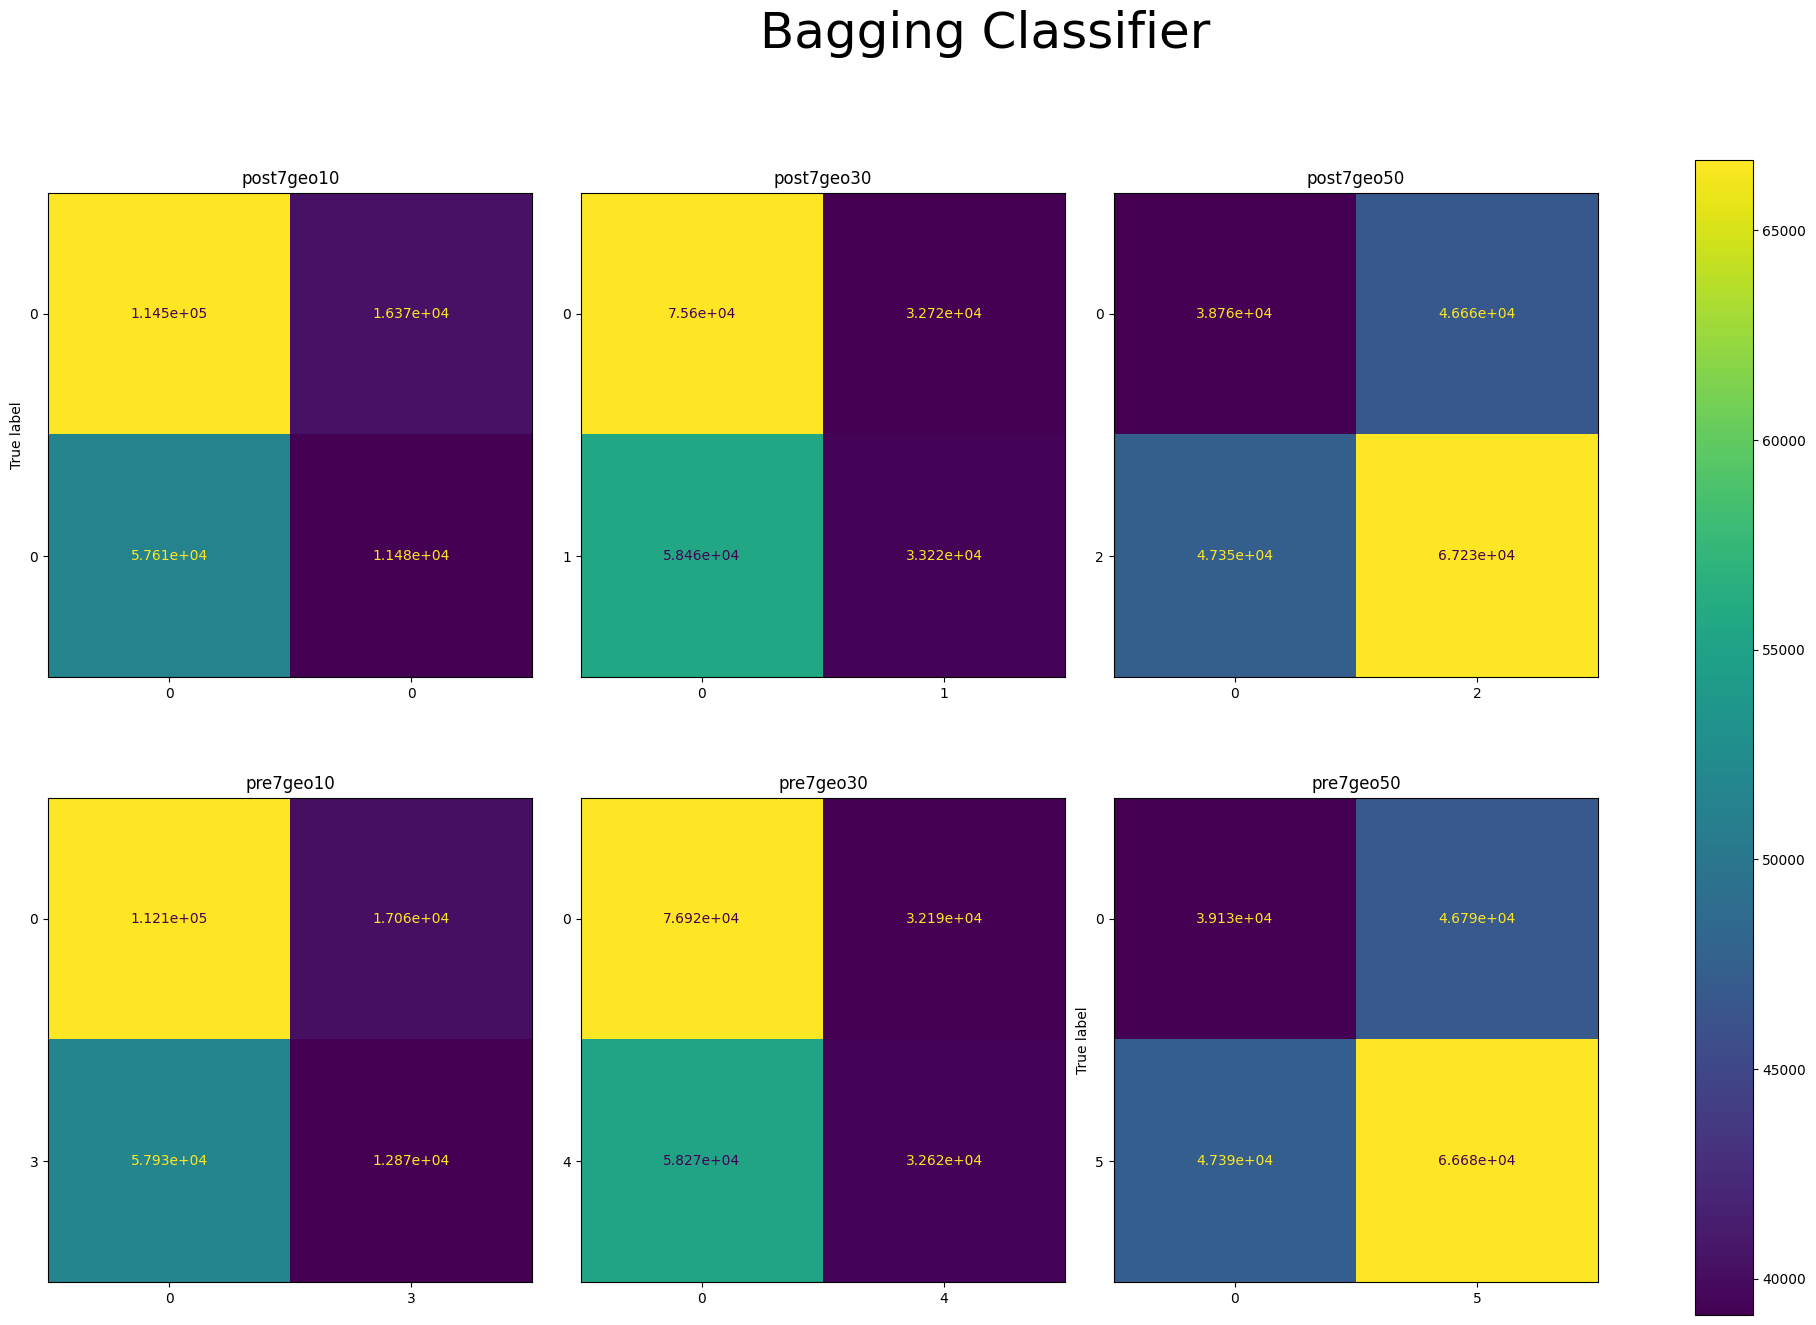

In [26]:
# Bagging Classifier
plot_confusion_matrix(y_test, bagPreds, "Bagging Classifier")

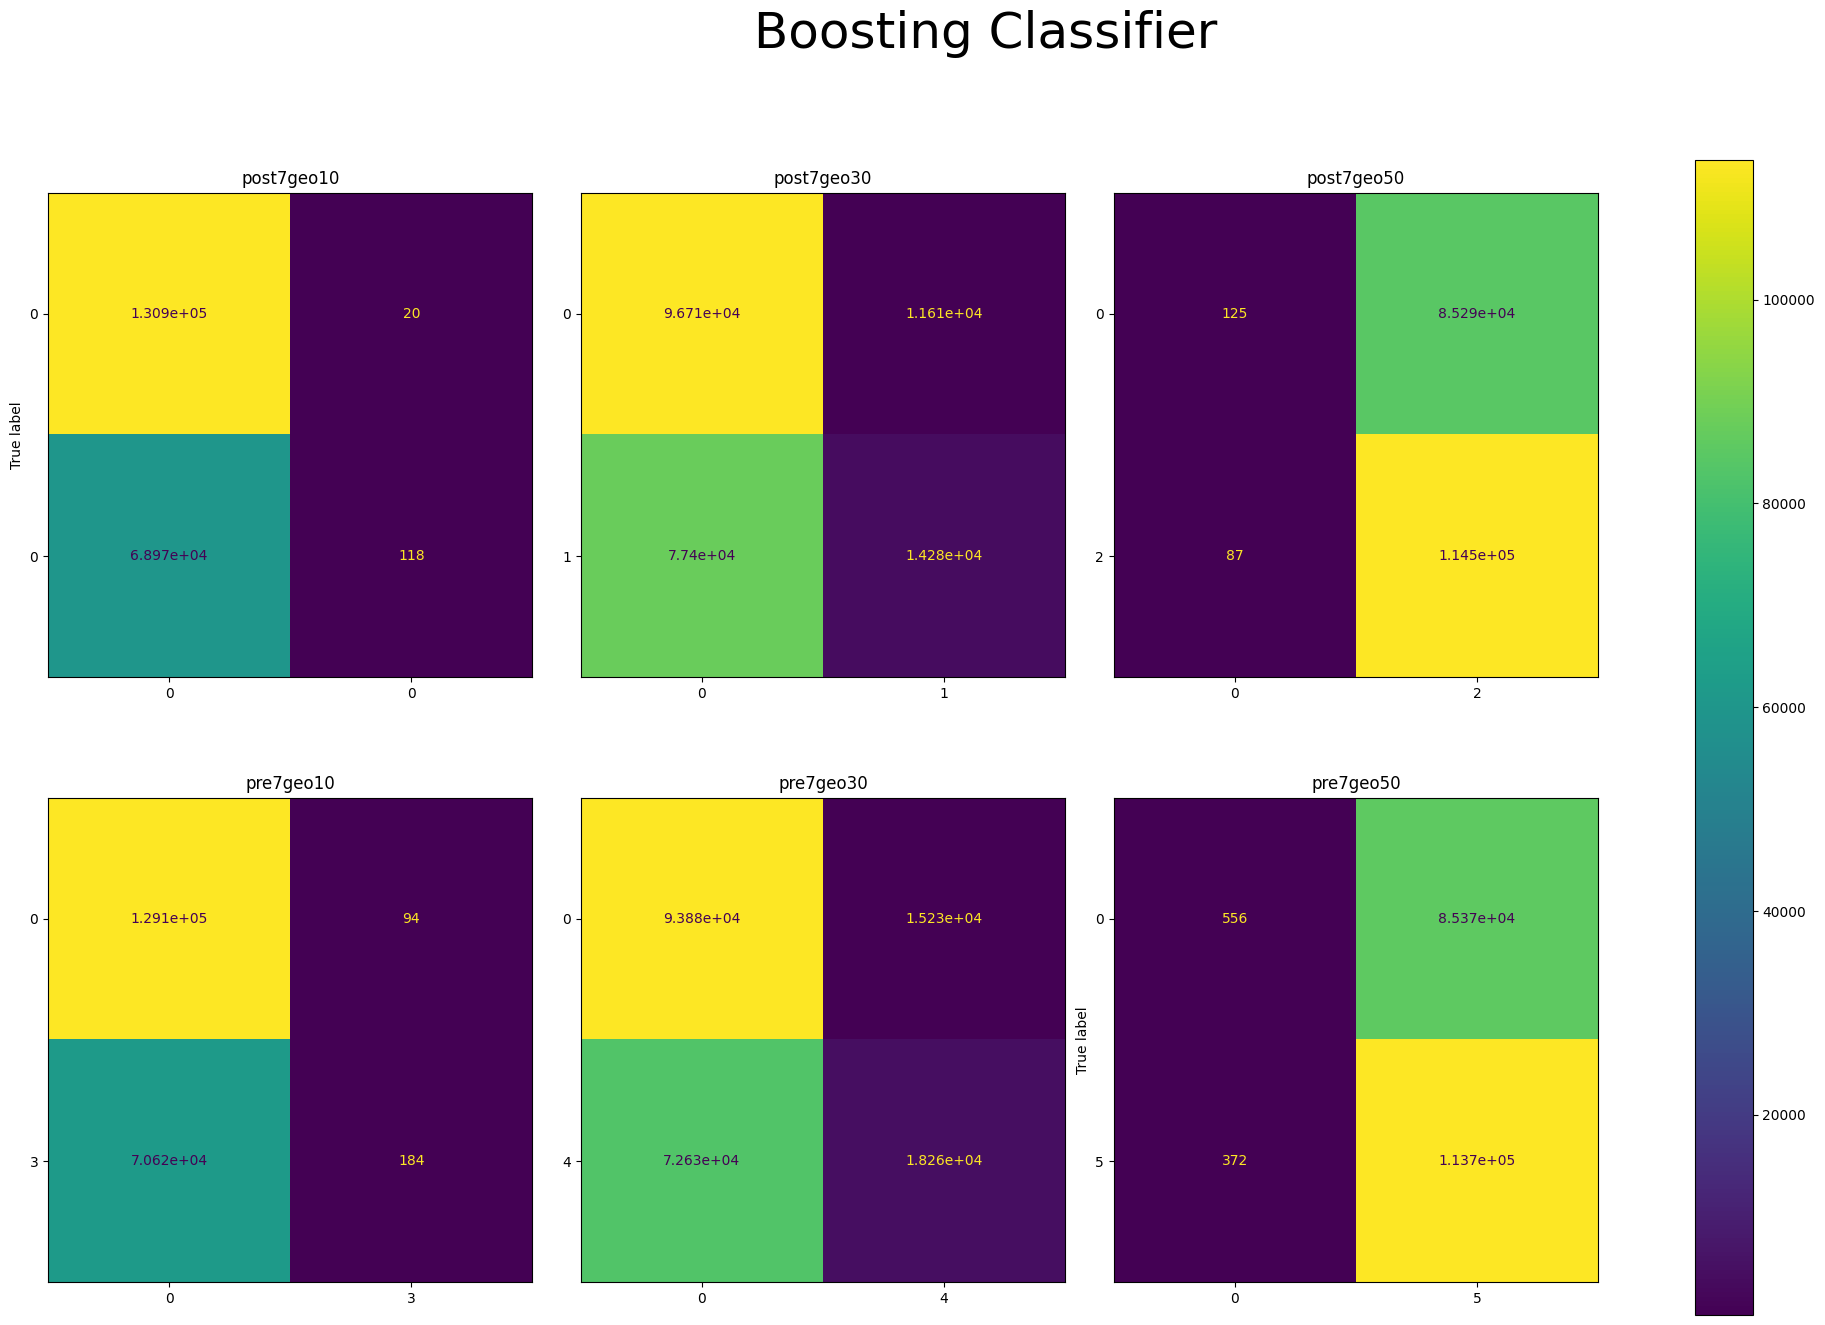

In [27]:
# Boosting Classifier
plot_confusion_matrix(y_test, boostPreds, "Boosting Classifier")

In [ ]:
# SVM-OVR Classifier
plot_confusion_matrix(y_test, svmPreds, "SVM - One vs Rest")

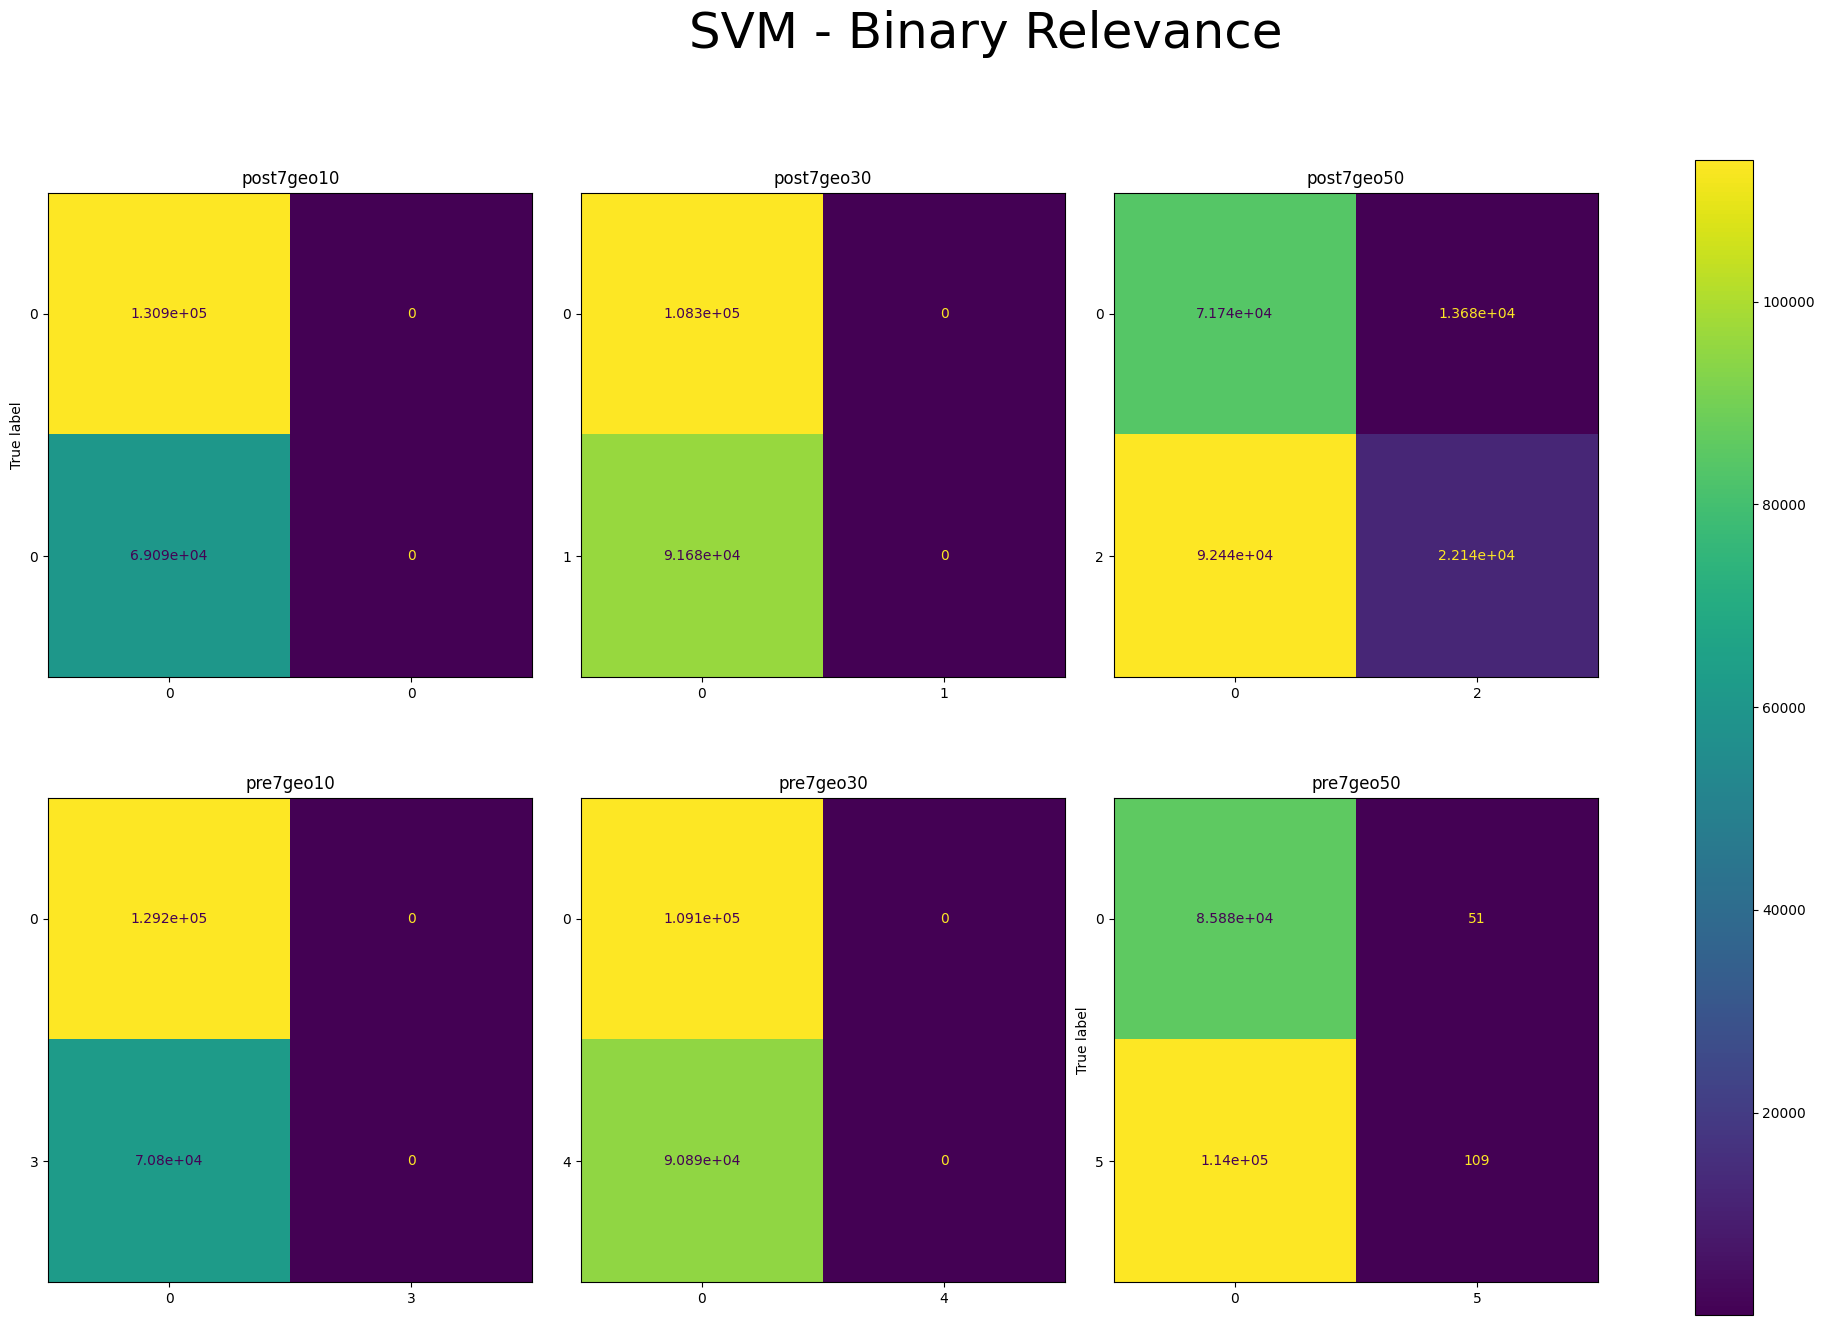

In [29]:
# SVM - Binary Relevance Classifier
plot_confusion_matrix(y_test, BinRelSVCPreds, "SVM - Binary Relevance")

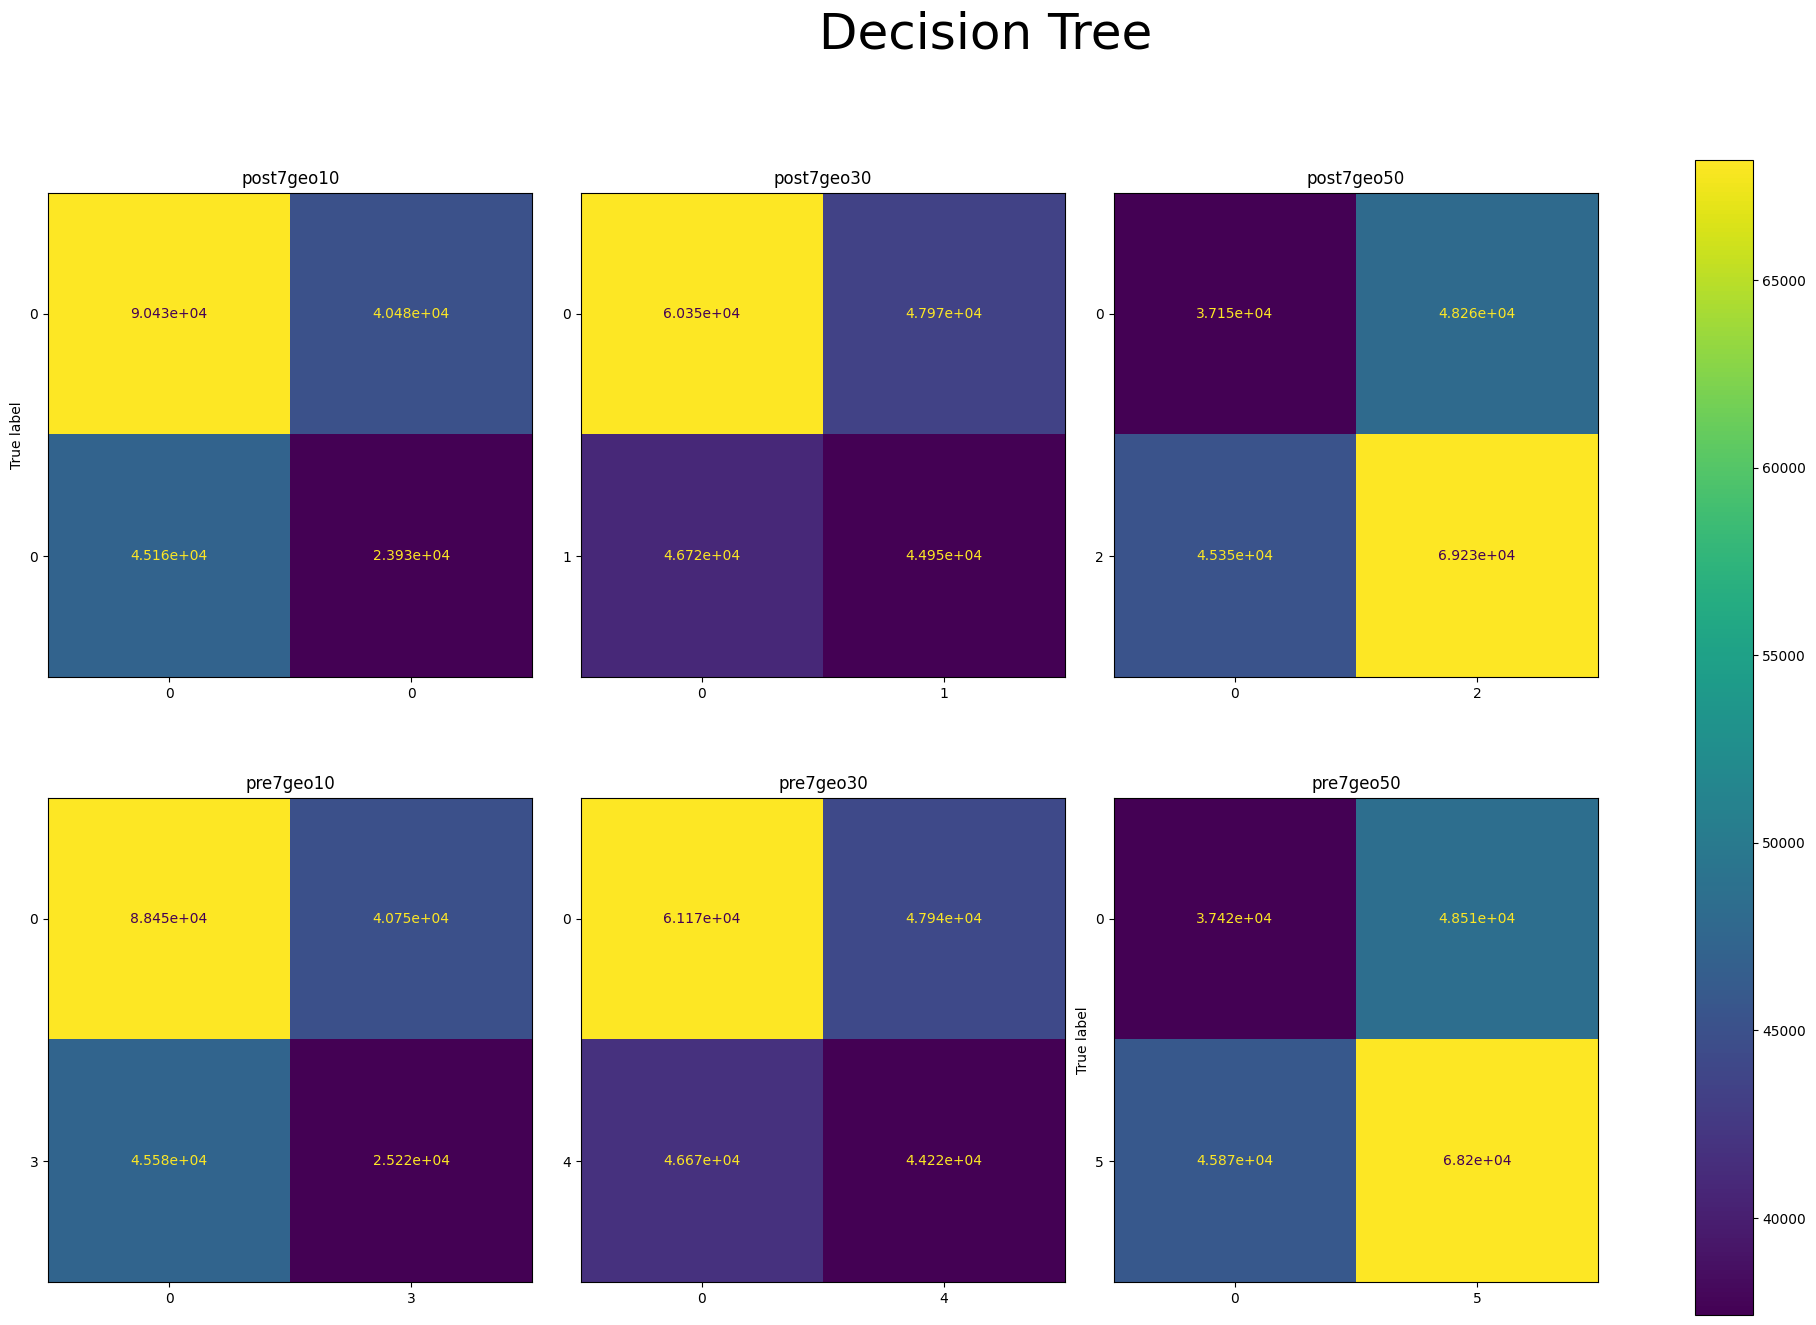

In [30]:
# Decision Trees Classifier
plot_confusion_matrix(y_test, dtPreds, "Decision Tree")

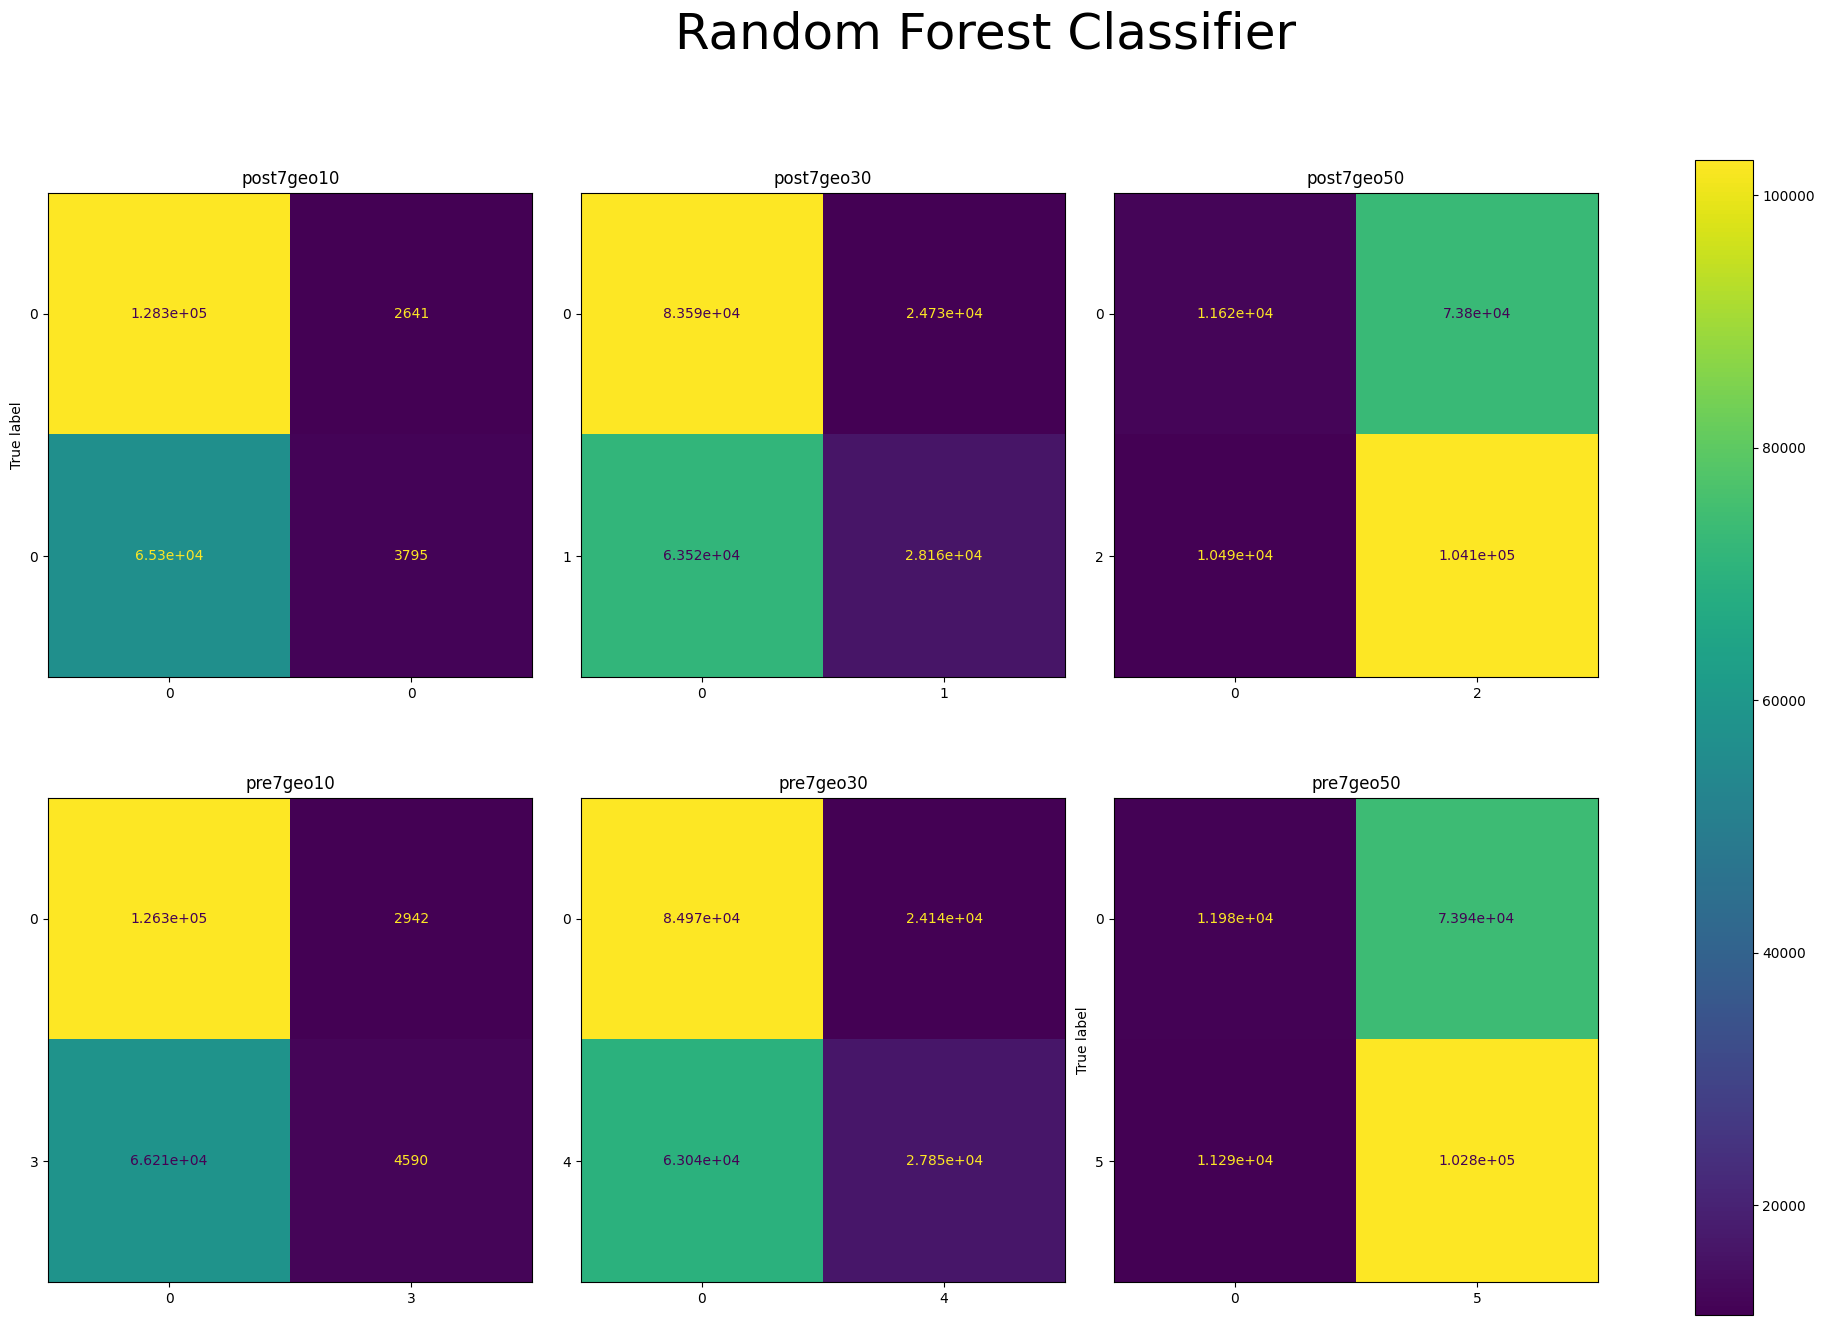

In [31]:
# Random Forest Classifier
plot_confusion_matrix(y_test, rfPreds, "Random Forest Classifier")

### Plot ROC Curve for the best classifier

/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/mmendieta/transformers/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc

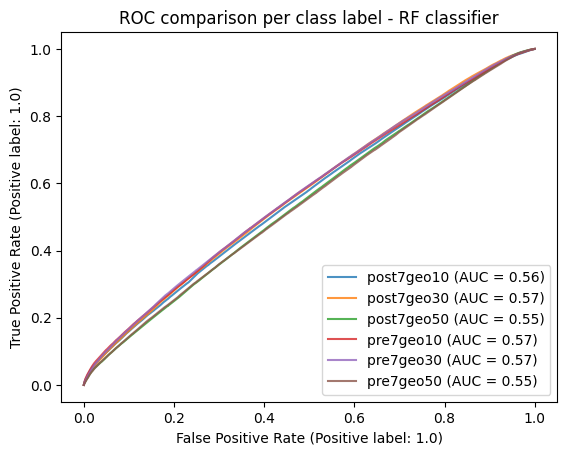

In [32]:
# Plot ROC Curve for the best classifier (RF)
label_names = ['post7geo10', 'post7geo30', 'post7geo50', 'pre7geo10','pre7geo30', 'pre7geo50']
labelPlots ={}
for i in range (len(label_names)):
    rfClassifier.fit(X_train, y_train[:,i])
    ax = plt.gca()
    labelPlots[i]= plot_roc_curve(rfClassifier, X_test, y_test[:,i], name= label_names[i], ax=ax, alpha=0.8) 

plt.title("ROC comparison per class label - RF classifier")
plt.show()